In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import random as rn
from keras.layers import Dense
from keras import Input
from keras.engine import Model
from keras.utils import to_categorical
from keras.layers import Dense, TimeDistributed, Dropout, Bidirectional, GRU, BatchNormalization, Activation, LeakyReLU, LSTM, Flatten, RepeatVector, Permute, Multiply, Conv2D, MaxPooling2D

https://m.blog.naver.com/PostView.nhn?blogId=sexyit_2019&logNo=221603292906&proxyReferer=https:%2F%2Fwww.google.com%2F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 오디오 데이터
DATA_DIR = '/content/drive/My Drive/졸프/합산_파일이름수정/'

In [ ]:
wav, sr = librosa.load(DATA_DIR + '음100.wav', sr=None)
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

FileNotFoundError: ignored

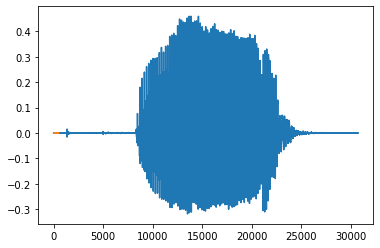

In [ ]:
# raw wave
print(plt.plot(wav))
print(plt.plot(wav[0:500]))

In [ ]:
train_X = []
train_spectrograms = []
train_mel_spectograms = []
train_mfccs = []
train_y = []

test_X = []
test_spectrograms = []
test_mel_spectograms = []
test_mfccs = []
test_y = []

pad1d = lambda a, i: a[0: i] if a.shape[0] > i else np.hstack((a, np.zeros(i-a.shape[0])))
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))

# STFT 한 것, CNN 분석하기 위해 Spectogram으로 만든 것, MF한 것, mel0spectogram 한 것


In [ ]:
from unicodedata import normalize

In [ ]:
dataset0 = [] # 어
dataset1 = [] # 음
dataset2 = [] # 그

In [ ]:
for filename in os.listdir(DATA_DIR):
  filename = normalize('NFC', filename)
  try:
    if '.wav' not in filename in filename:
      continue
      
    wav, sr = librosa.load(DATA_DIR + filename)
    padded_x = pad1d(wav, 30000)
    mfcc = librosa.feature.mfcc(wav)
    padded_mfcc = pad2d(mfcc, 40)

    # 추임새 별로 dataset에 추가
    if filename[0] == '어':
      dataset0.append((padded_x, padded_mfcc, 0))
    elif filename[0] == '음':
      dataset1.append((padded_x, padded_mfcc, 1))
    elif filename[0] == '그':
      dataset2.append((padded_x, padded_mfcc, 2))
  except Exception as e:
    print(filename, e)
    raise

# 추임새 별 데이터셋을 셔플한 후 testset과 trainset으로 split
import random
random.shuffle(dataset0)
random.shuffle(dataset1)
random.shuffle(dataset2)

test_dataset = []
train_dataset = []

cutoff = int(len(dataset0) * 0.2)
test_dataset.extend(dataset0[:cutoff])
train_dataset.extend(dataset0[cutoff:])

cutoff = int(len(dataset1) * 0.2)
test_dataset.extend(dataset1[:cutoff])
train_dataset.extend(dataset1[cutoff:])

cutoff = int(len(dataset2) * 0.2)
test_dataset.extend(dataset2[:cutoff])
train_dataset.extend(dataset2[cutoff:])

random.shuffle(test_dataset)
random.shuffle(train_dataset)

train_X = [a for (a,b,c) in train_dataset]
train_mfccs = [b for (a,b,c) in train_dataset]
train_y = [c for (a,b,c) in train_dataset]

test_X = [a for (a,b,c) in test_dataset]
test_mfccs = [b for (a,b,c) in test_dataset]
test_y = [c for (a,b,c) in test_dataset]

train_X = np.vstack(train_X)
train_mfccs = np.array(train_mfccs)
train_y = to_categorical(np.array(train_y))

test_X = np.vstack(test_X)
test_mfccs = np.array(test_mfccs)
test_y = to_categorical(np.array(test_y))

print('train_X:', train_X.shape)
print('train_mfccs:', train_mfccs.shape)
print('train_y:', train_y.shape)

print('test_X:', test_X.shape)
print('test_mfccs:', test_mfccs.shape)
print('test_y:', test_y.shape)


train_X: (530, 30000)
train_mfccs: (530, 20, 40)
train_y: (530, 3)
test_X: (130, 30000)
test_mfccs: (130, 20, 40)
test_y: (130, 3)


In [ ]:
ip = Input(shape = (train_X[0].shape))
hidden = Dense(128, activation='relu')(ip)
op = Dense(3, activation='softmax')(hidden)
model = Model(input=ip, output=op)

model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 30000)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               3840128   
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 387       
Total params: 3,840,515
Trainable params: 3,840,515
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  after removing the cwd from sys.path.


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X,
                    train_y,
                    epochs=10,
                    batch_size=32,
                    validation_data=(test_X, test_y))

Train on 530 samples, validate on 130 samples
Epoch 1/10
530/530 [==============================] - 1s 2ms/step - loss: 1.2161 - accuracy: 0.3528 - val_loss: 1.3153 - val_accuracy: 0.3615
Epoch 2/10
530/530 [==============================] - 1s 2ms/step - loss: 0.4638 - accuracy: 0.8302 - val_loss: 1.4115 - val_accuracy: 0.3846
Epoch 3/10
530/530 [==============================] - 1s 2ms/step - loss: 0.3243 - accuracy: 0.9038 - val_loss: 1.5136 - val_accuracy: 0.3692
Epoch 4/10
530/530 [==============================] - 1s 2ms/step - loss: 0.2570 - accuracy: 0.9283 - val_loss: 1.5981 - val_accuracy: 0.3923
Epoch 5/10
530/530 [==============================] - 1s 2ms/step - loss: 0.2168 - accuracy: 0.9396 - val_loss: 1.6707 - val_accuracy: 0.3923
Epoch 6/10
530/530 [==============================] - 1s 2ms/step - loss: 0.1875 - accuracy: 0.9528 - val_loss: 1.7452 - val_accuracy: 0.3923
Epoch 7/10
530/530 [==============================] - 1s 2ms/step - loss: 0.1651 - accuracy: 0.9679 - 

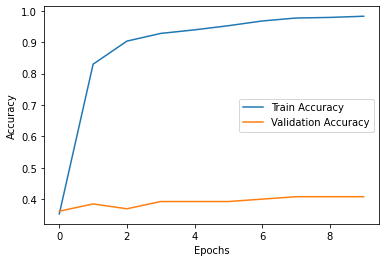

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
train_X_ex = np.expand_dims(train_mfccs, -1)
test_X_ex = np.expand_dims(test_mfccs, -1)
print('train X shape:', train_X_ex.shape)
print('test X shape:', test_X_ex.shape)

train X shape: (530, 20, 40, 1)
test X shape: (130, 20, 40, 1)


In [ ]:
ip = Input(shape=train_X_ex[0].shape)
m = Conv2D(64, kernel_size=(4,4), activation='relu')(ip)
m = MaxPooling2D(pool_size=(4,4))(m)
# m = Conv2D(128, kernel_size=(2,2), activation='relu')(ip)
# m = MaxPooling2D(pool_size=(2,2))(m)
m = Flatten()(m)
m = Dense(32, activation='relu')(m)
op = Dense(3, activation='softmax')(m)

model = Model(input=ip, output=op)

model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 20, 40, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 37, 64)        1088      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 9, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                73760     
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 99        
Total params: 74,947
Trainable params: 74,947
Non-trainable params: 0
_______________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X_ex,
                    train_y,
                    epochs=100,
                    batch_size=32,
                    verbose=1,
                    validation_data=(test_X_ex, test_y))

Train on 530 samples, validate on 130 samples
Epoch 1/100
530/530 [==============================] - 0s 772us/step - loss: 6.4129 - accuracy: 0.4623 - val_loss: 2.2851 - val_accuracy: 0.5231
Epoch 2/100
530/530 [==============================] - 0s 613us/step - loss: 1.0777 - accuracy: 0.7623 - val_loss: 0.8529 - val_accuracy: 0.7077
Epoch 3/100
530/530 [==============================] - 0s 618us/step - loss: 0.6394 - accuracy: 0.8000 - val_loss: 0.6263 - val_accuracy: 0.8231
Epoch 4/100
530/530 [==============================] - 0s 606us/step - loss: 0.4050 - accuracy: 0.8472 - val_loss: 0.4797 - val_accuracy: 0.8308
Epoch 5/100
530/530 [==============================] - 0s 614us/step - loss: 0.3078 - accuracy: 0.8925 - val_loss: 0.4394 - val_accuracy: 0.8077
Epoch 6/100
530/530 [==============================] - 0s 610us/step - loss: 0.2248 - accuracy: 0.9113 - val_loss: 0.3923 - val_accuracy: 0.8615
Epoch 7/100
530/530 [==============================] - 0s 570us/step - loss: 0.2314 

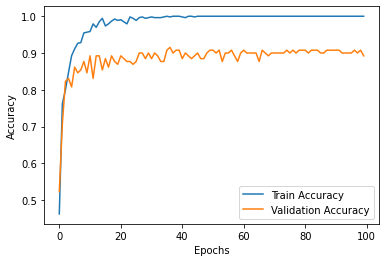

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# 샘플 오디오 데이터
DATA_DIR = '/content/drive/My Drive/졸프/'

wav, sr = librosa.load(DATA_DIR + 'sample.m4a', sr=None)
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 44100
wav shape: (1651712,)
length: 37.45378684807256 secs


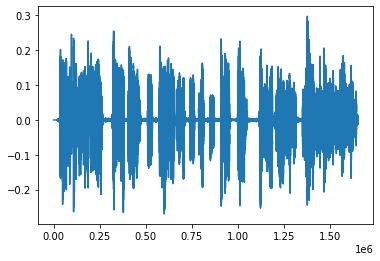

In [ ]:
# raw wave
print(plt.plot(wav))
print(plt.plot(wav[0:500]))

In [ ]:
wav, sr = librosa.load(DATA_DIR + 'sample.m4a')
padded_x = pad1d(wav, 30000)
mfcc = librosa.feature.mfcc(wav)
padded_mfcc = pad2d(mfcc, 40)
padded_mfcc = np.expand_dims(padded_mfcc, -1)

In [ ]:
model.predict(padded_mfcc)

ValueError: ignored